In [1]:
import sys
sys.path.append('../code/')

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import pacf, acf

from preprocessing_utils import preprocess_df
from plot_utils import plot_store_charts, plot_folds
from test_utils import run_stat_test
from sm_utils import compute_pacf_acf, StatmodelsWrapper, run_k_fold_tain_val_statmodels

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

# Upload data

In [2]:
ts = pd.read_csv('../data/US1.NVDA_200101_210215.csv', delimiter=';')
ts = preprocess_df(ts)
ts

,ticker,per,date,time,open,high,low,close,vol,Nclose
0,US1.NVDA,D,2020-01-02,0,238.85,239.88,236.73,239.79,303428,0.392886
1,US1.NVDA,D,2020-01-03,0,234.65,237.81,234.17,236.37,268936,0.387282
2,US1.NVDA,D,2020-01-06,0,232.21,237.25,231.52,237.07,432624,0.388429
3,US1.NVDA,D,2020-01-07,0,238.03,241.76,236.39,239.83,576787,0.392951
4,US1.NVDA,D,2020-01-08,0,239.65,242.04,238.15,240.42,540373,0.393918
...,...,...,...,...,...,...,...,...,...,...
275,US1.NVDA,D,2021-02-08,0,549.96,578.93,549.96,577.70,316219,0.946537
276,US1.NVDA,D,2021-02-09,0,574.02,583.00,568.90,570.35,142242,0.934494
277,US1.NVDA,D,2021-02-10,0,579.02,596.20,574.45,590.72,320581,0.967870
278,US1.NVDA,D,2021-02-11,0,599.50,610.89,597.61,610.33,268265,1.000000


# Observation

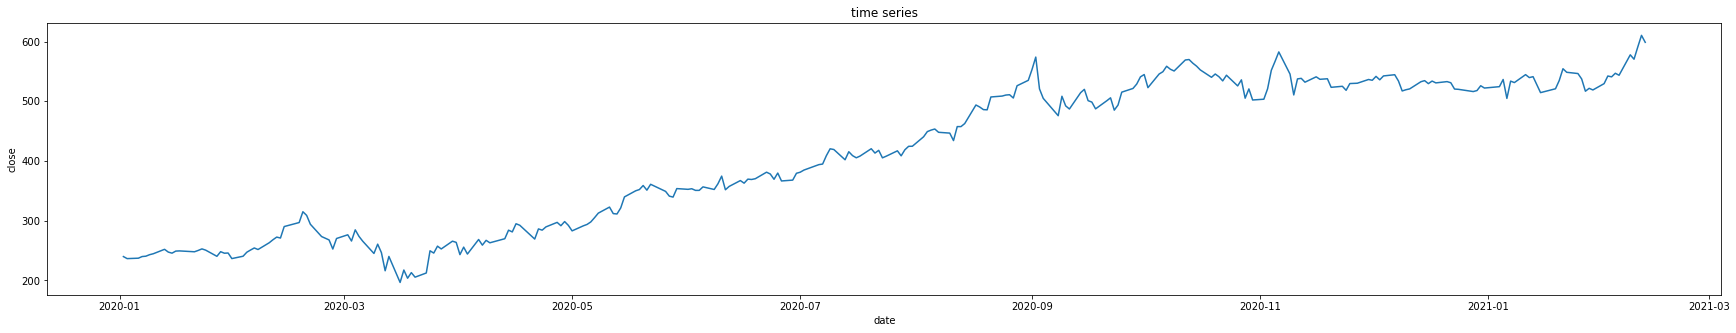

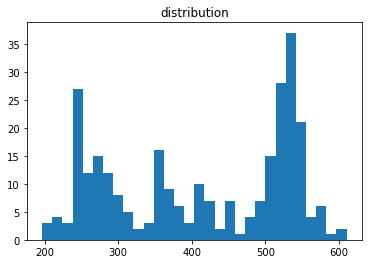

In [3]:
plot_store_charts(ts)

# Checks for Stationarity

In [4]:
test_results = {}
test_results.update(run_stat_test(ts['close'], adfuller))
test_results.update(run_stat_test(ts['close'], kpss, 3))

pd.Series(test_results)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


adfuller_statistics           -0.530404
adfuller_p_value               0.885946
adfuller_critical_value_1%    -3.454355
adfuller_critical_value_5%    -2.872108
adfuller_critical_value_10%   -2.572401
kpss_statistics                1.673479
kpss_p_value                   0.010000
kpss_critical_value_10%        0.347000
kpss_critical_value_5%         0.463000
kpss_critical_value_2.5%       0.574000
kpss_critical_value_1%         0.739000
dtype: float64

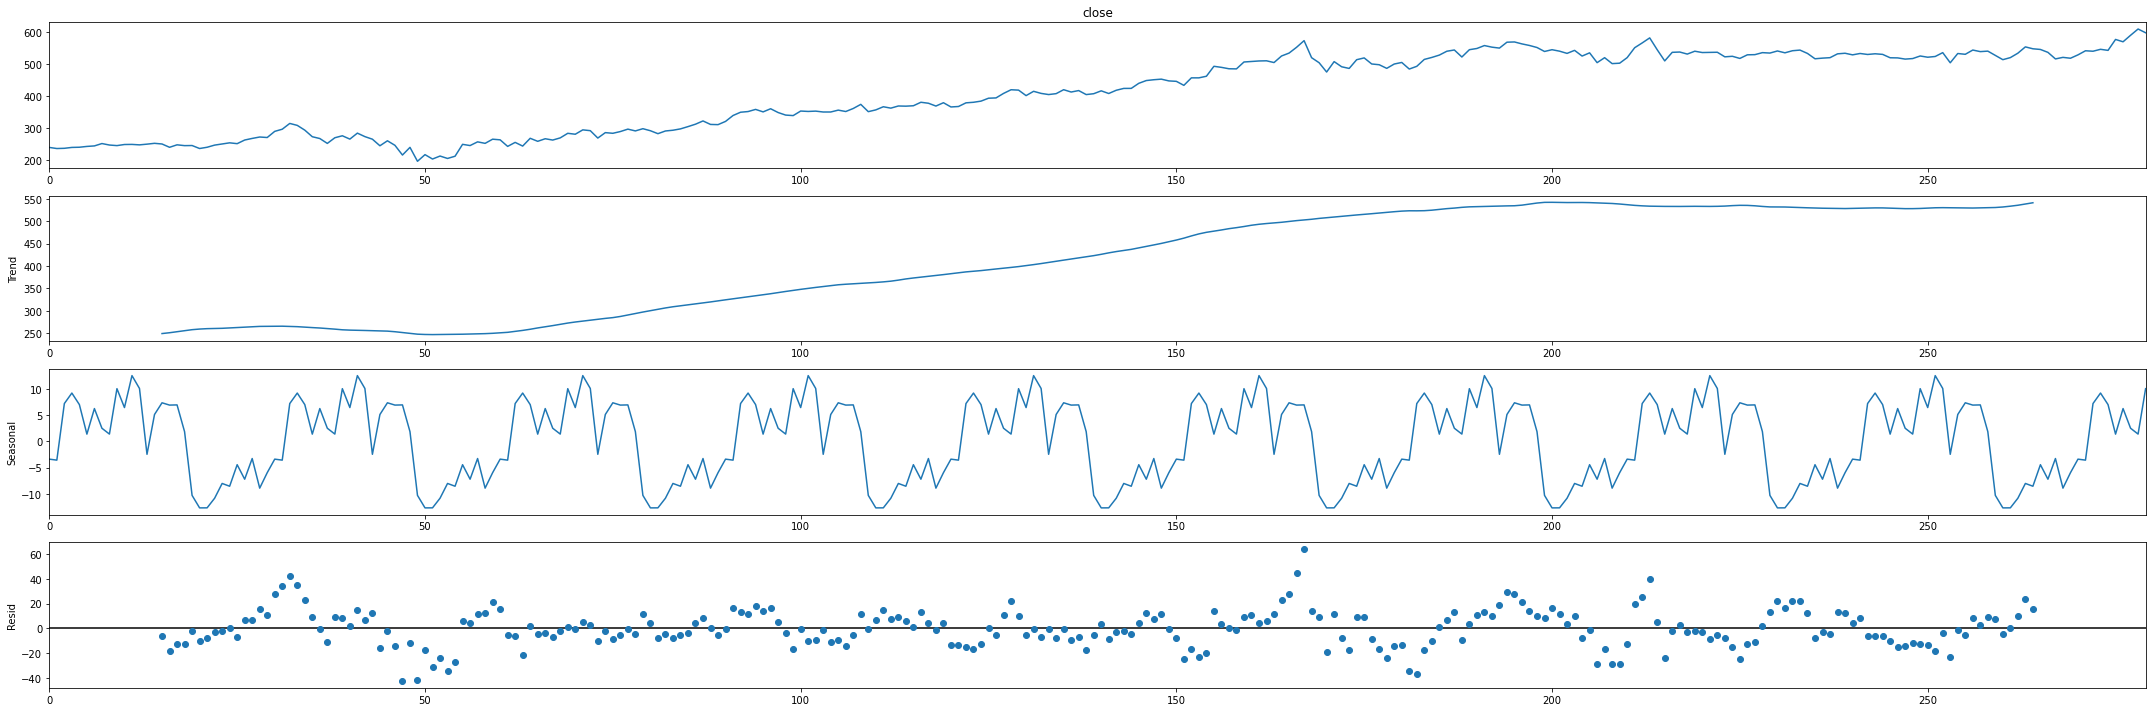

In [5]:
plt.rcParams.update({'figure.figsize': (30,10)})
sesonal_dec = seasonal_decompose(ts['close'], period=30)
sesonal_dec.plot()
plt.show()

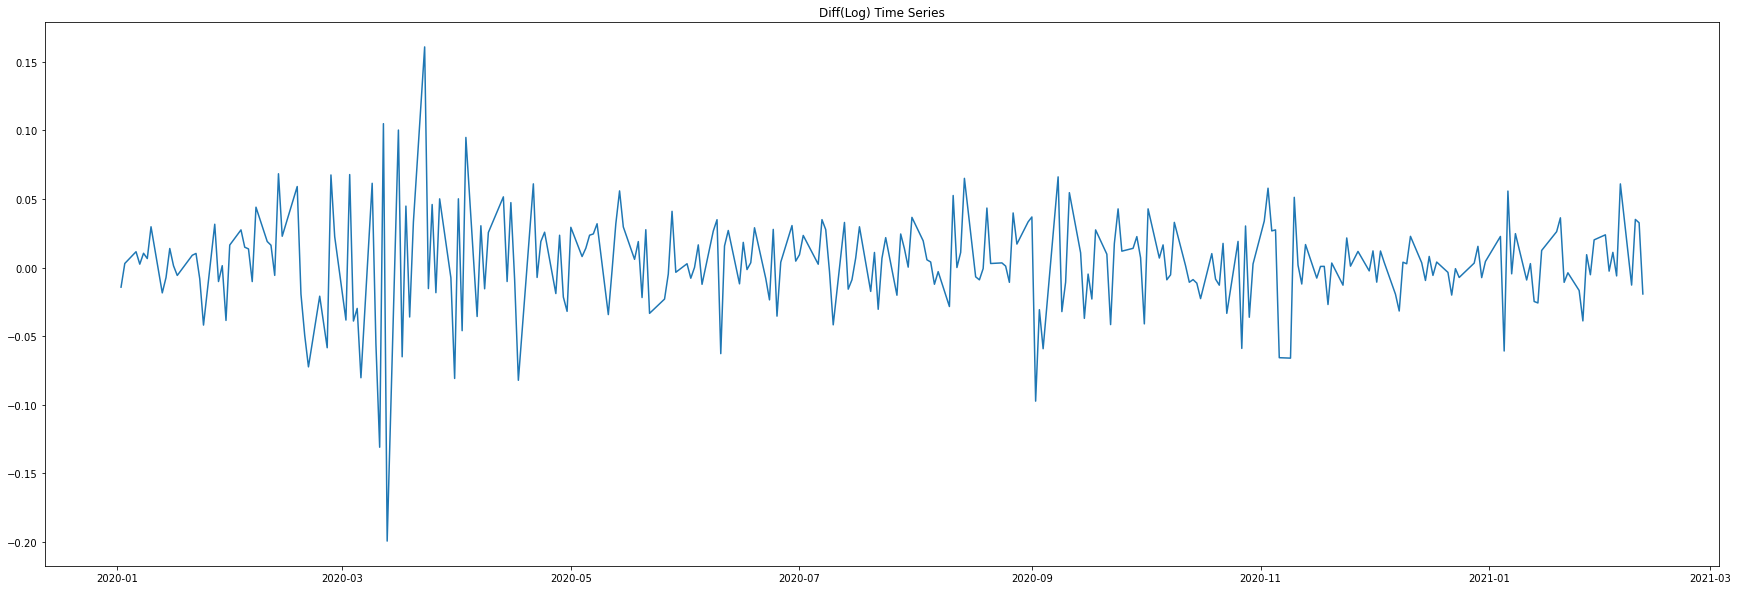

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


adfuller_statistics           -6.673431e+00
adfuller_p_value               4.527275e-09
adfuller_critical_value_1%    -3.454622e+00
adfuller_critical_value_5%    -2.872225e+00
adfuller_critical_value_10%   -2.572464e+00
kpss_statistics                8.068829e-02
kpss_p_value                   1.000000e-01
kpss_critical_value_10%        3.470000e-01
kpss_critical_value_5%         4.630000e-01
kpss_critical_value_2.5%       5.740000e-01
kpss_critical_value_1%         7.390000e-01
dtype: float64

In [6]:
processed_closed = np.log1p(ts['close']).diff(periods=1).dropna().reset_index(drop=True)

plt.title('Diff(Log) Time Series')
plt.plot(ts['date'].iloc[:-1], processed_closed)
plt.show()

processed_test_results = {}
processed_test_results.update(run_stat_test(processed_closed, adfuller))
processed_test_results.update(run_stat_test(processed_closed, kpss, 3))

pd.Series(processed_test_results)

# Train/Test splitting

In [7]:
test_file_period = 7
train_file_period = ts['date'].max() - ts['date'].min()
print(f"Test file period {test_file_period}\nTrain file period {train_file_period}")

Test file period 7
Train file period 407 days 00:00:00


In [8]:
fold_ids = list(TimeSeriesSplit(test_size=test_file_period).split(ts))

# Trim start in order to have same size folds
train_fold_len = min([len(el[0]) for el in fold_ids])
for i in range(len(fold_ids)):
    fold_ids[i] = (fold_ids[i][0][-train_fold_len:], fold_ids[i][1])

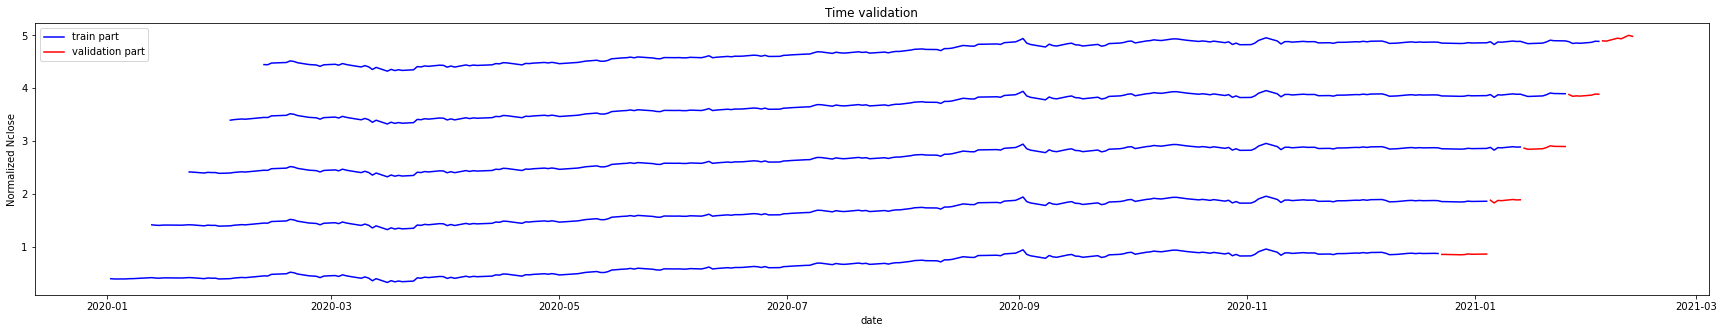

In [9]:
plot_folds(ts, fold_ids)

# ARMA

==== Fold 0 Starting
Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


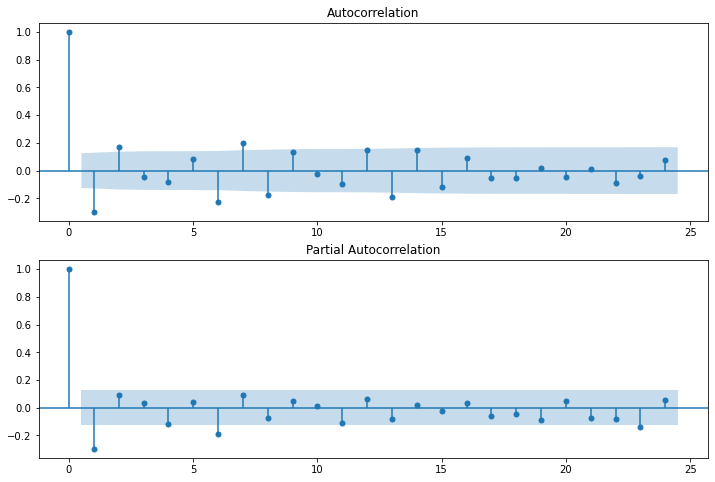

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


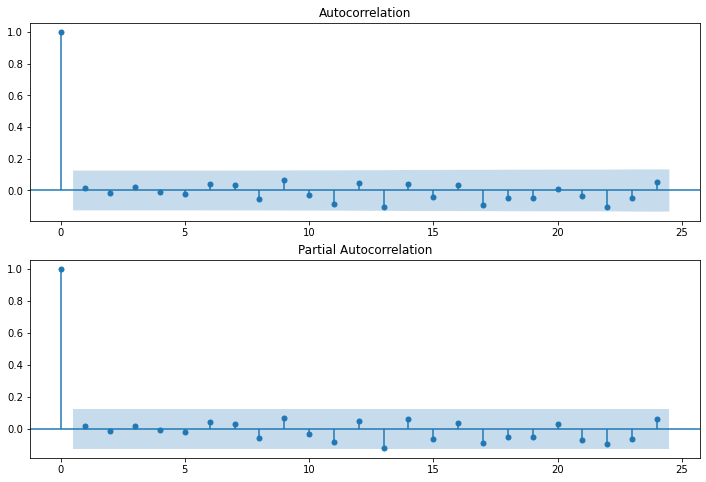

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  0%|          | 0/7 [00:00<?, ?it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 14%|█▍        | 1/7 [00:00<00:02,  2.31it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 29%|██▊       | 2/7 [00:00<00:02,  2.18it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:                 ARIMA(6, 0, 1)   Log Likelihood                 495.343
Date:                Wed, 17 Feb 2021   AIC                           -972.687
Time:                        18:16:23   BIC                           -940.958
Sample:                             0   HQIC                          -959.918
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.874      0.061      -0.000       0.007
ar.L1         -0.6955      0.202     -3.440      0.001      -1.092      -0.299
ar.L2         -0.0265      0.083     -0.320      0.7

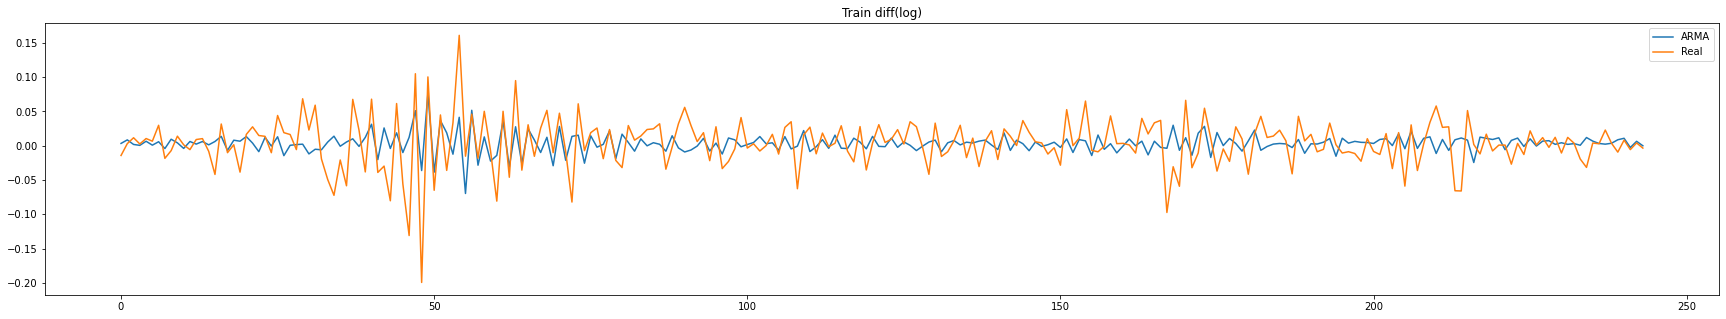

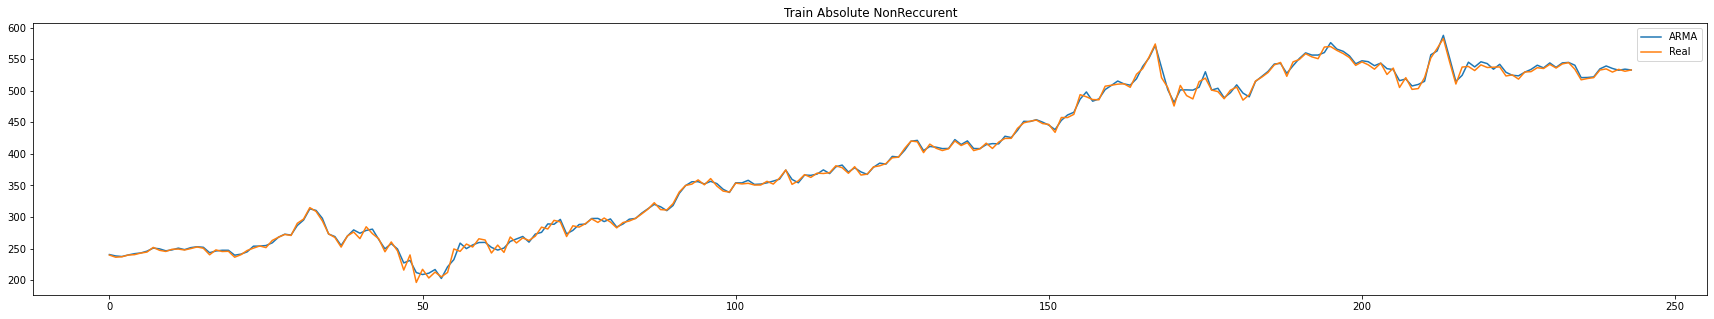

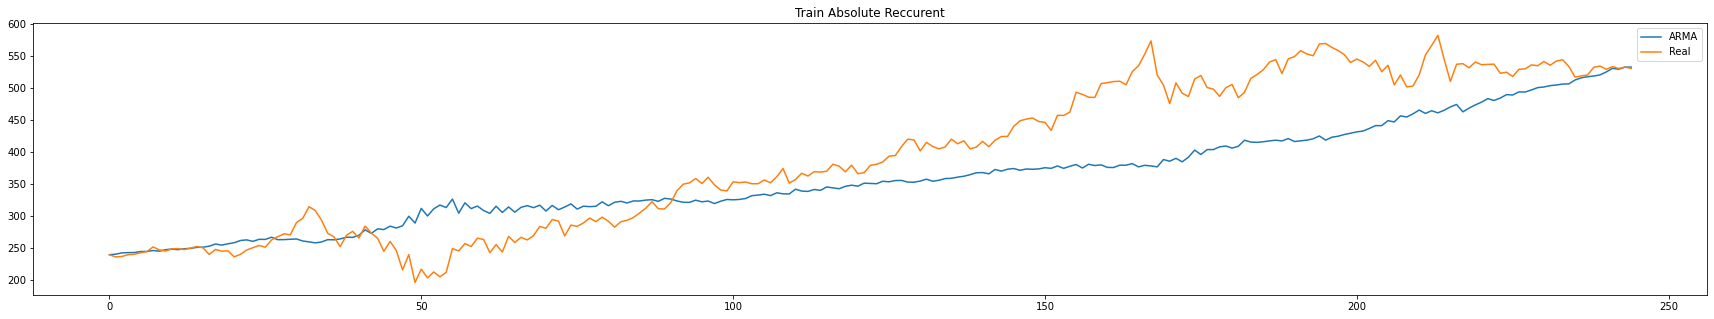

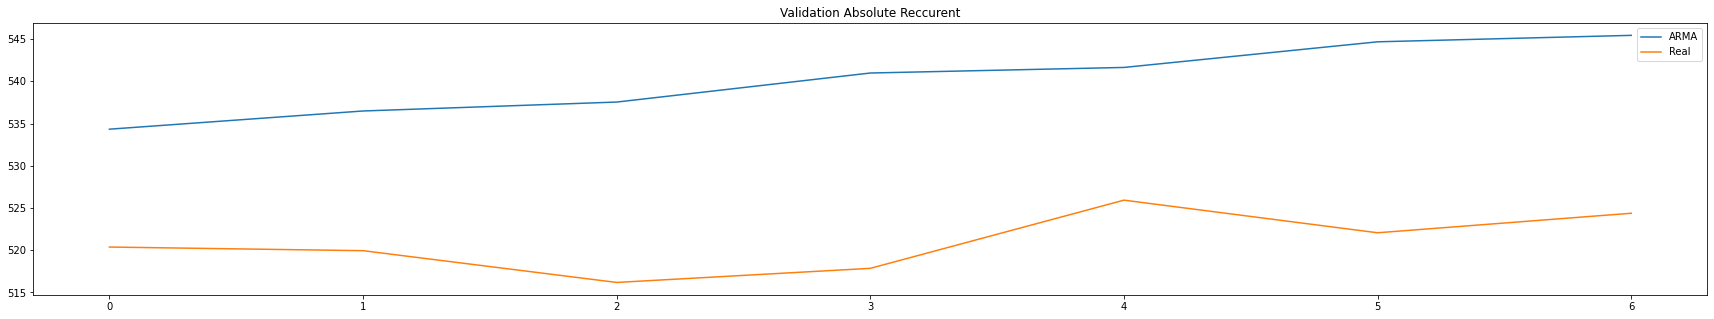

mse_train: 52.31524719634054
mse_valid: 19.188709574414993
==== Fold 0 Completed
==== Fold 1 Starting
Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


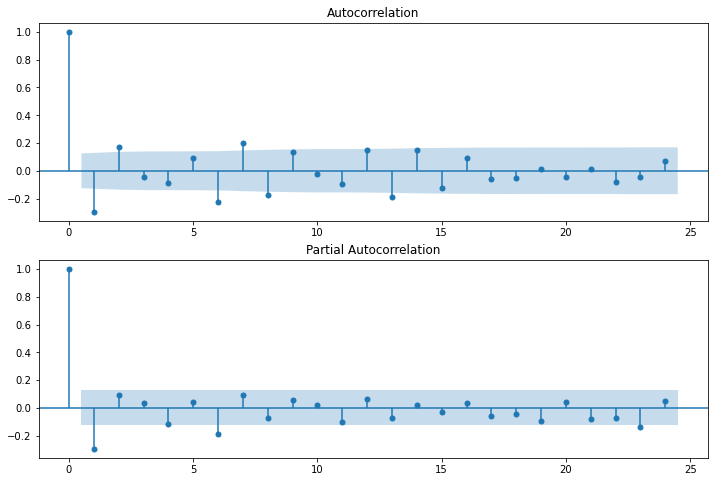

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


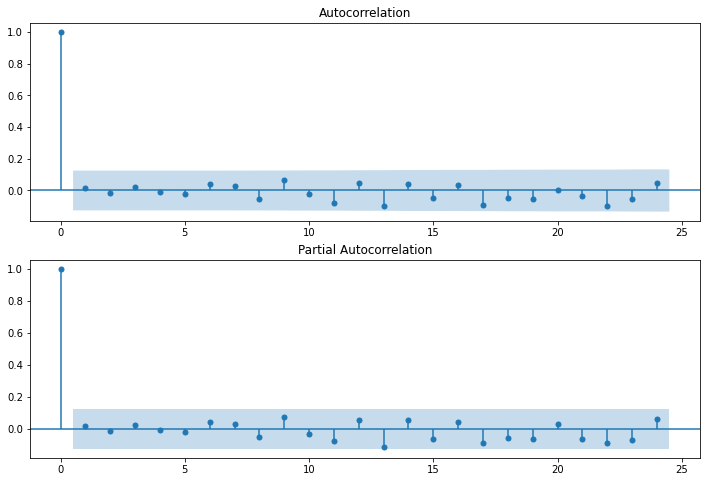

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  0%|          | 0/7 [00:00<?, ?it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 14%|█▍        | 1/7 [00:00<00:02,  2.35it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 29%|██▊       | 2/7 [00:00<00:02,  2.34it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:                 ARIMA(6, 0, 1)   Log Likelihood                 495.201
Date:                Wed, 17 Feb 2021   AIC                           -972.401
Time:                        18:16:28   BIC                           -940.672
Sample:                             0   HQIC                          -959.633
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.002      1.737      0.082      -0.000       0.006
ar.L1         -0.7032      0.198     -3.544      0.000      -1.092      -0.314
ar.L2         -0.0266      0.082     -0.323      0.7

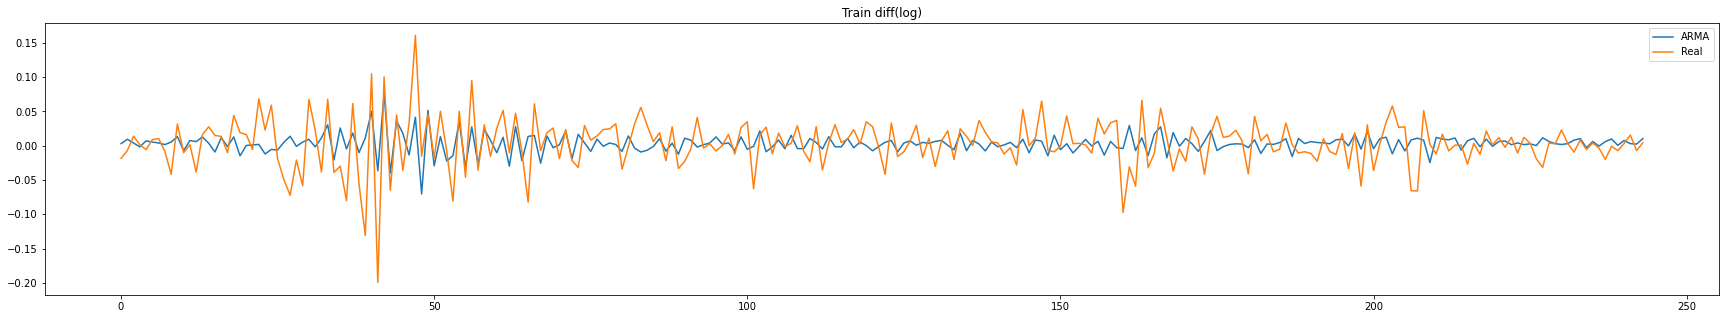

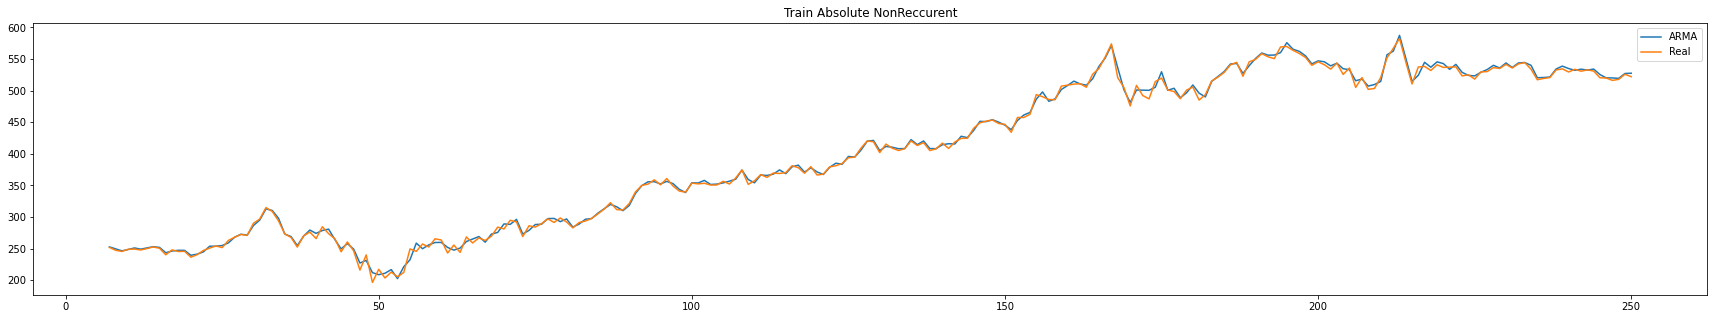

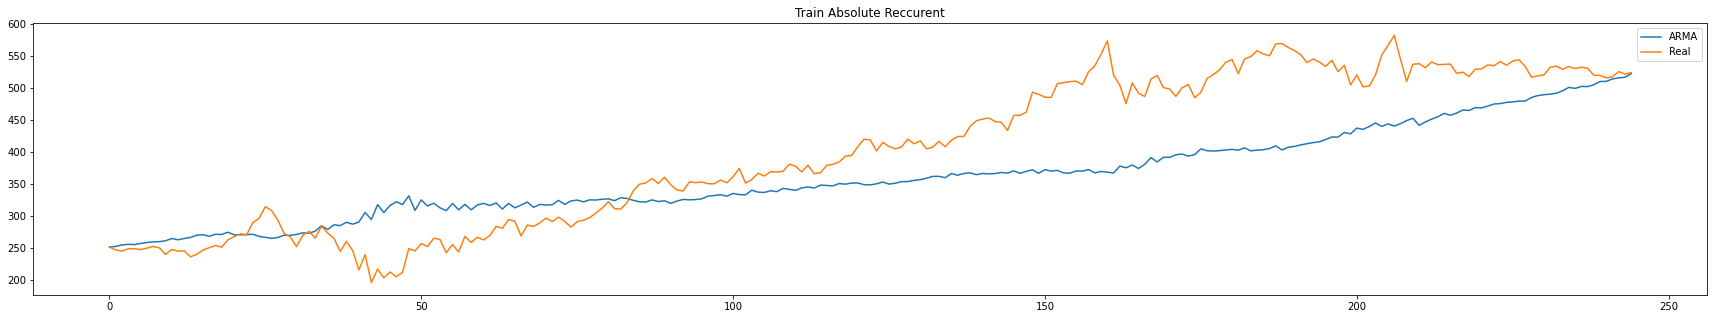

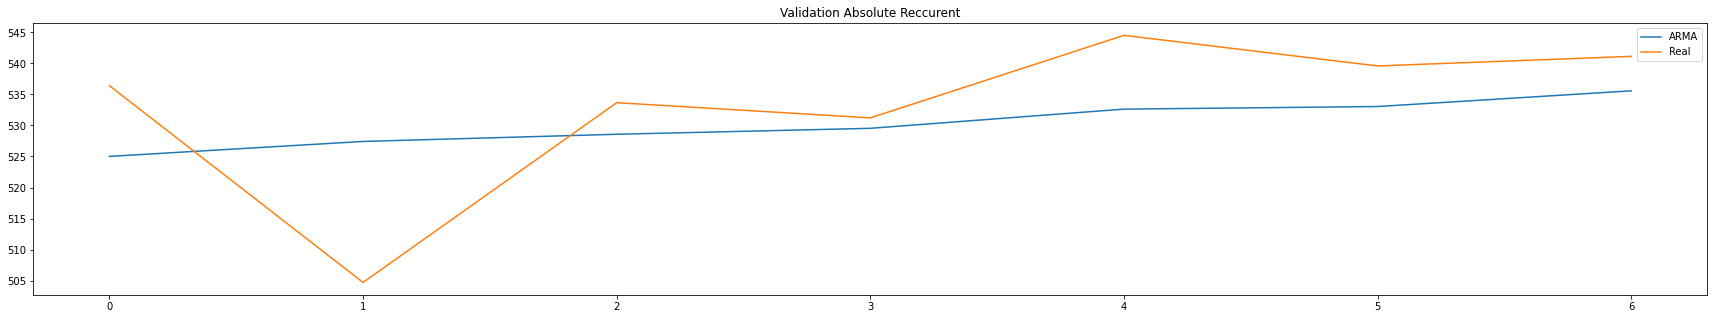

mse_train: 60.87819494124954
mse_valid: 9.267145896137444
==== Fold 1 Completed
==== Fold 2 Starting
Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


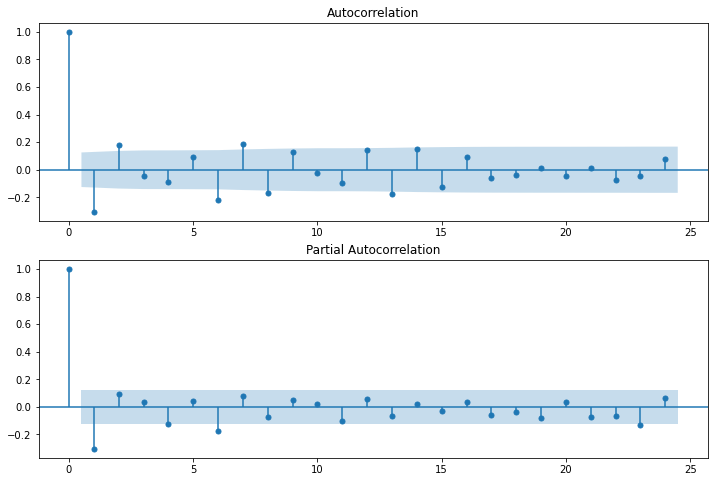

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


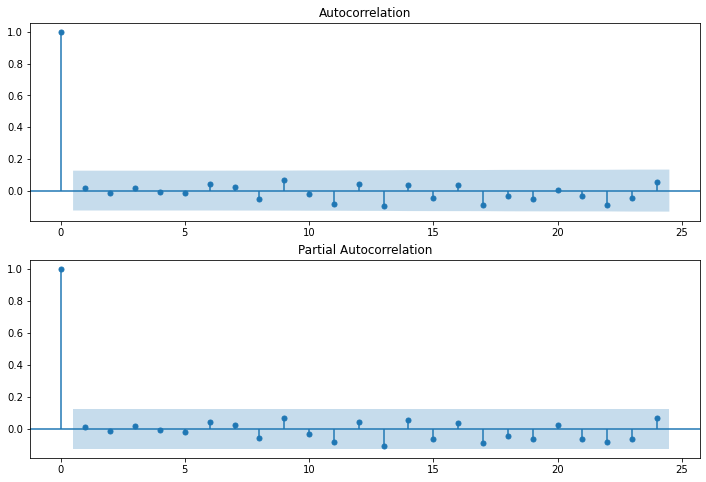

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  0%|          | 0/7 [00:00<?, ?it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 14%|█▍        | 1/7 [00:00<00:02,  2.08it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 29%|██▊       | 2/7 [00:00<00:02,  2.09it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:                 ARIMA(6, 0, 1)   Log Likelihood                 492.956
Date:                Wed, 17 Feb 2021   AIC                           -967.912
Time:                        18:16:33   BIC                           -936.183
Sample:                             0   HQIC                          -955.144
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.761      0.078      -0.000       0.007
ar.L1         -0.6626      0.212     -3.125      0.002      -1.078      -0.247
ar.L2         -0.0021      0.085     -0.025      0.9

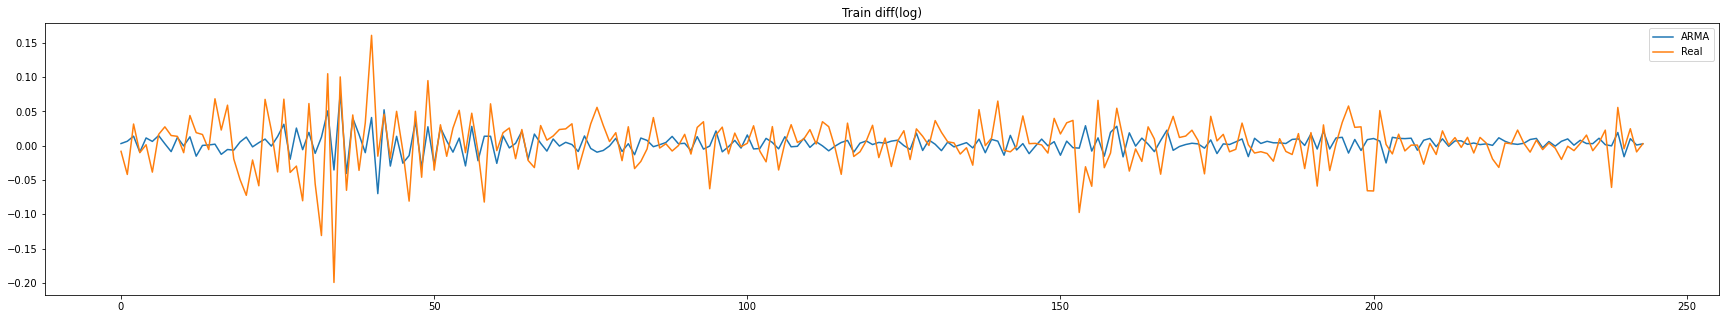

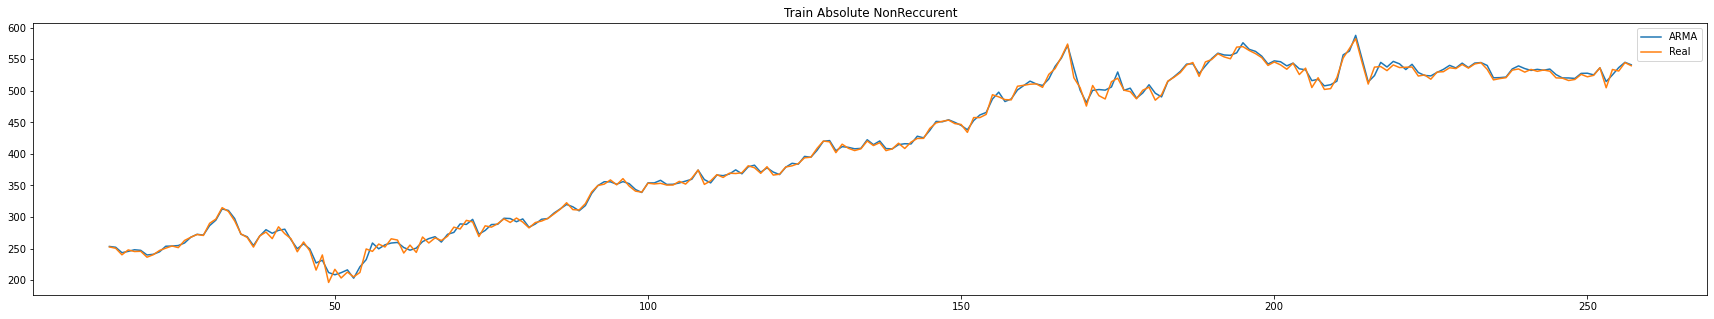

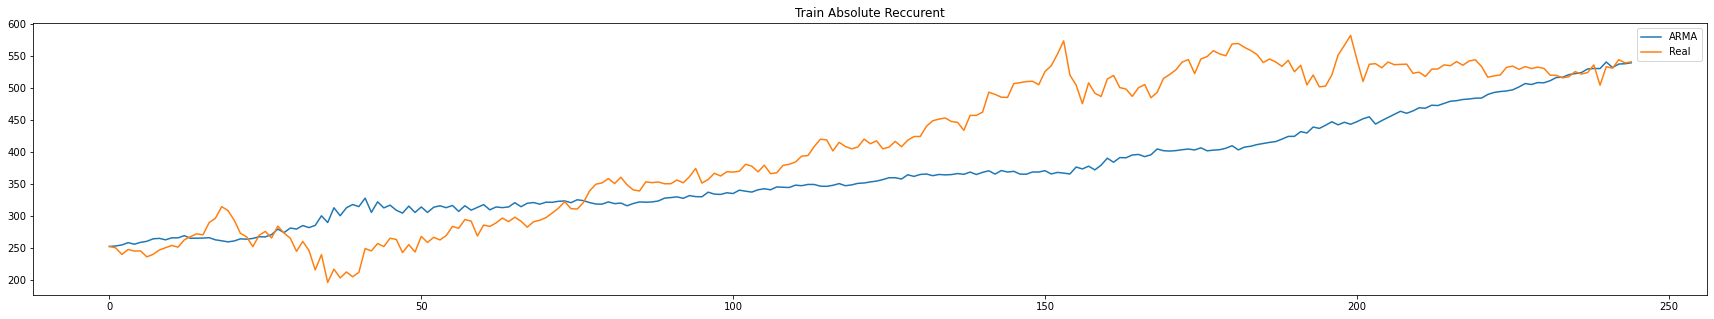

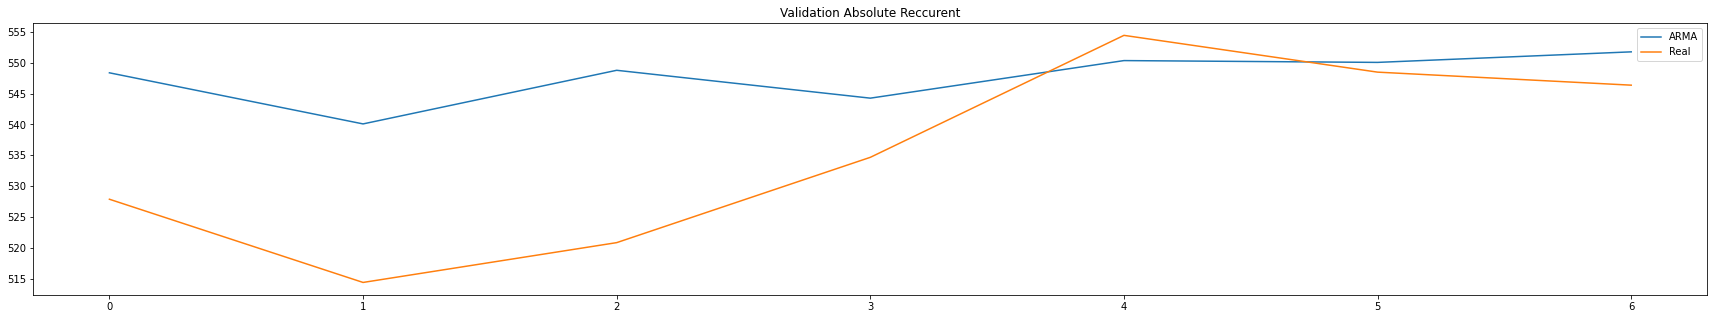

mse_train: 60.0672694809856
mse_valid: 13.533632835553476
==== Fold 2 Completed
==== Fold 3 Starting
Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


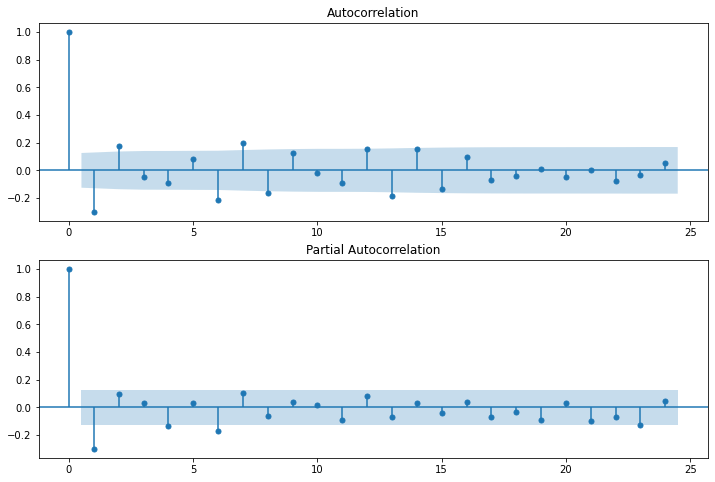

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


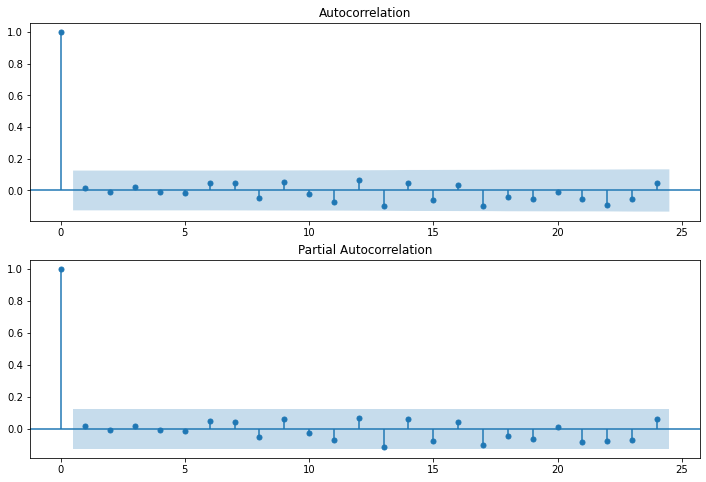

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  0%|          | 0/7 [00:00<?, ?it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 14%|█▍        | 1/7 [00:00<00:02,  2.29it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 29%|██▊       | 2/7 [00:00<00:02,  2.19it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:                 ARIMA(6, 0, 1)   Log Likelihood                 493.158
Date:                Wed, 17 Feb 2021   AIC                           -968.316
Time:                        18:16:38   BIC                           -936.587
Sample:                             0   HQIC                          -955.548
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.897      0.058      -0.000       0.007
ar.L1         -0.6867      0.214     -3.205      0.001      -1.107      -0.267
ar.L2         -0.0196      0.086     -0.227      0.8

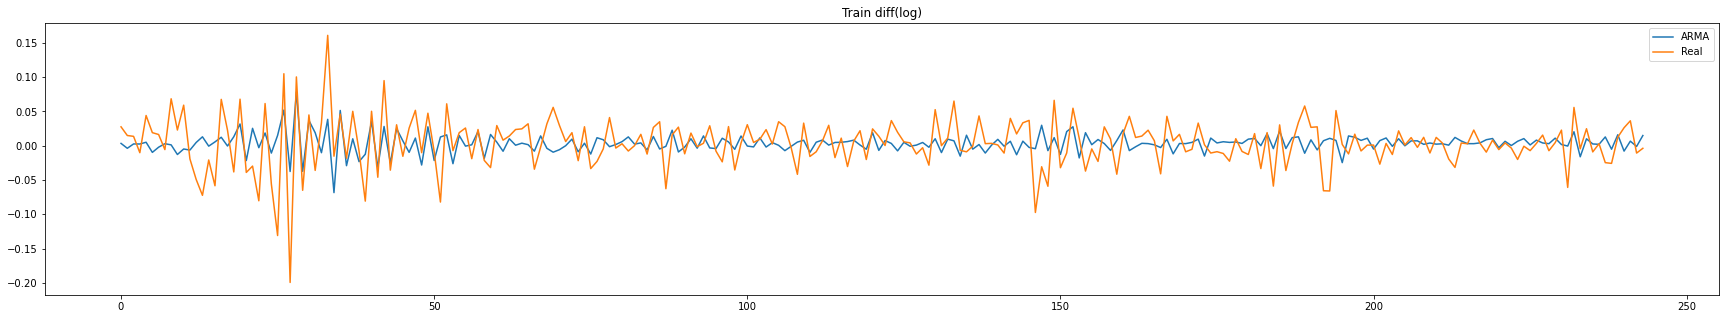

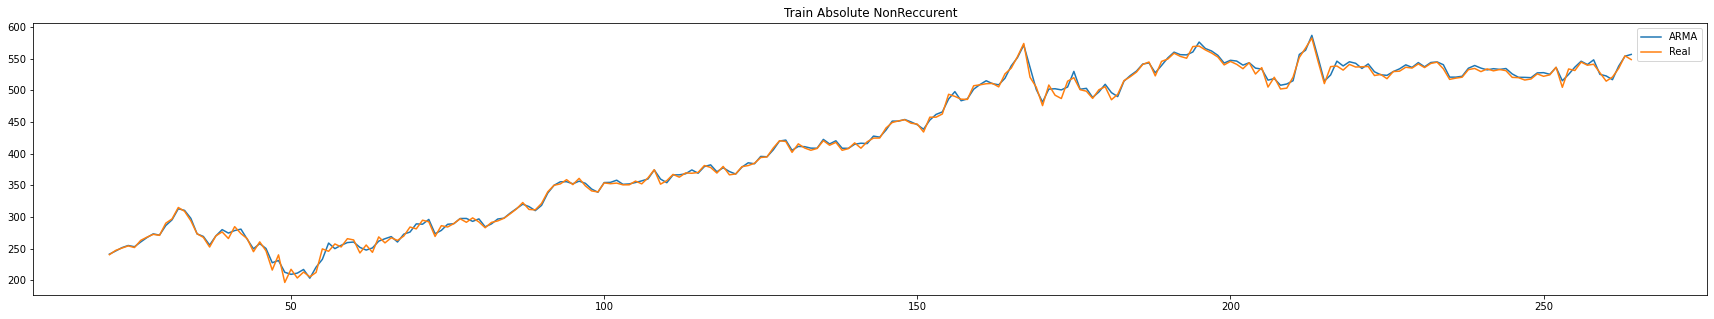

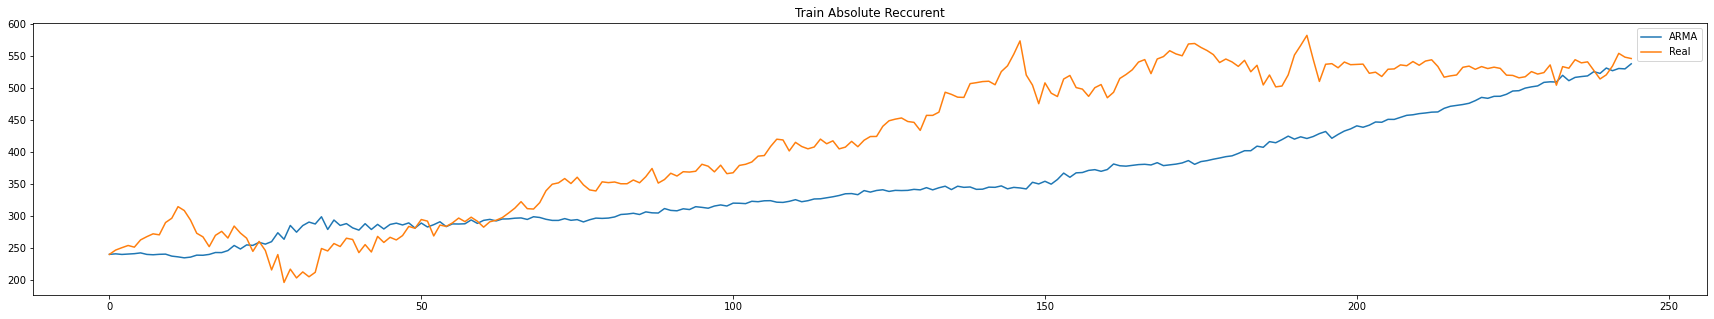

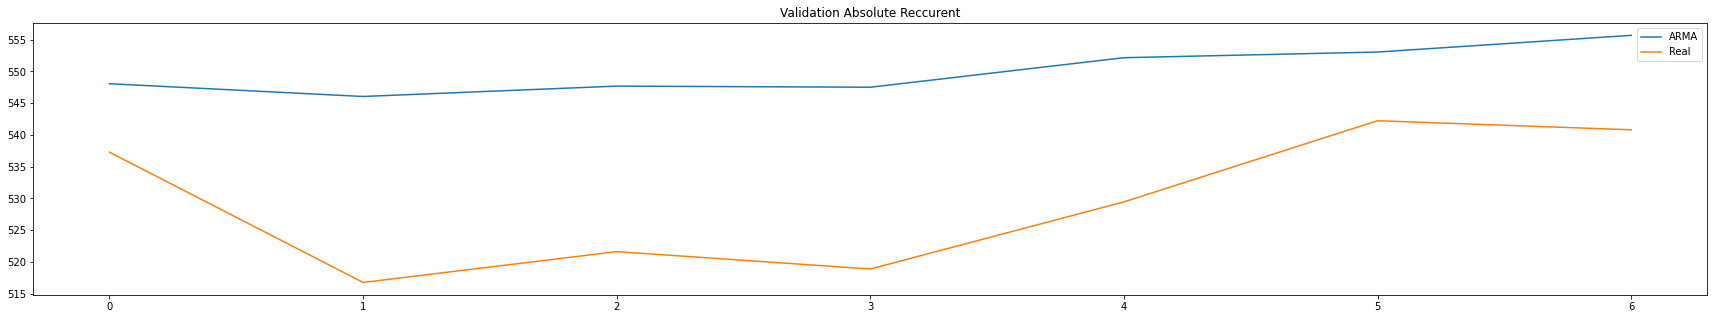

mse_train: 73.24007432467978
mse_valid: 20.46573921170128
==== Fold 3 Completed
==== Fold 4 Starting
Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


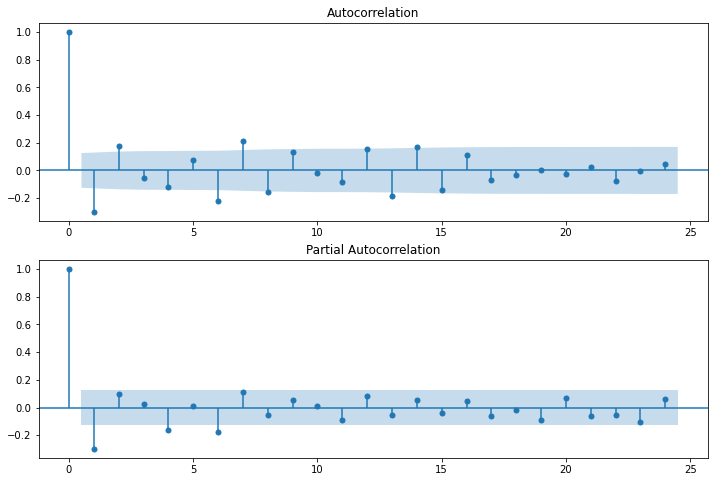

Residual ACF/PACF


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


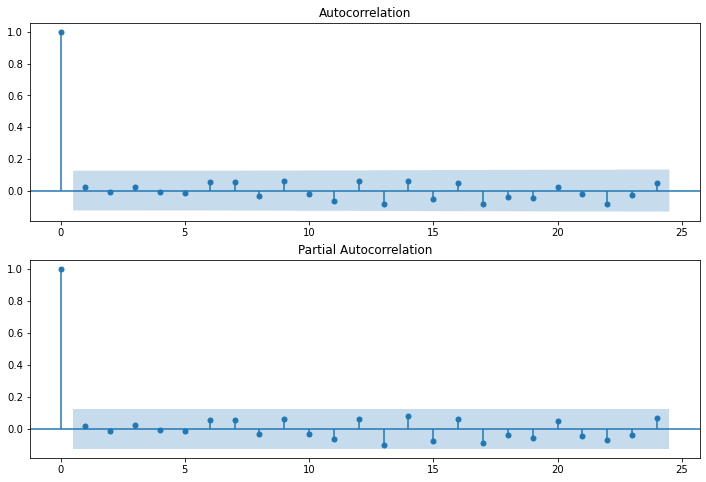

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  0%|          | 0/7 [00:00<?, ?it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 14%|█▍        | 1/7 [00:00<00:02,  2.06it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 29%|██▊       | 2/7 [00:00<00:02,  2.06it/s]/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:                 ARIMA(6, 0, 1)   Log Likelihood                 494.889
Date:                Wed, 17 Feb 2021   AIC                           -971.778
Time:                        18:16:43   BIC                           -940.049
Sample:                             0   HQIC                          -959.009
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.661      0.097      -0.000       0.006
ar.L1         -0.7121      0.197     -3.617      0.000      -1.098      -0.326
ar.L2         -0.0307      0.084     -0.364      0.7

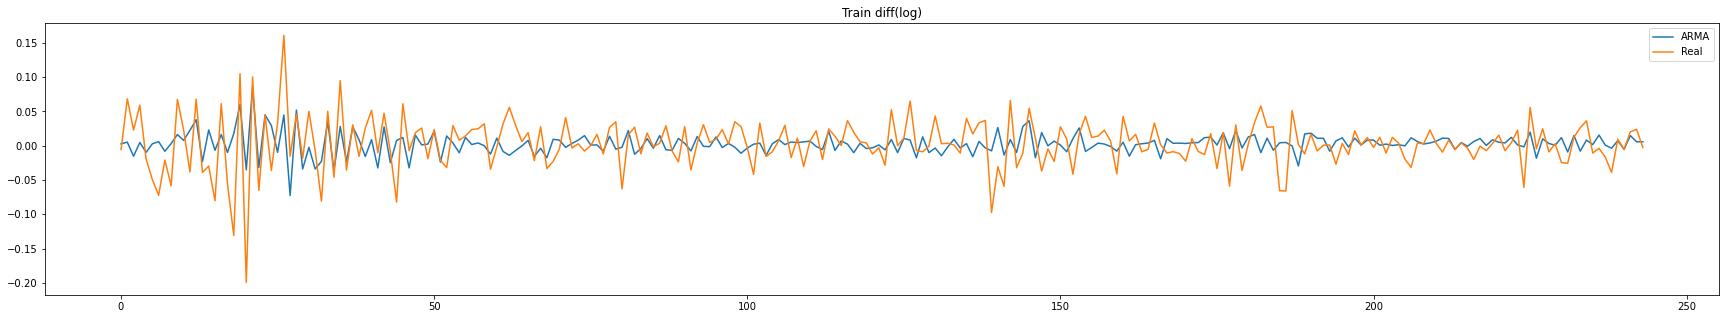

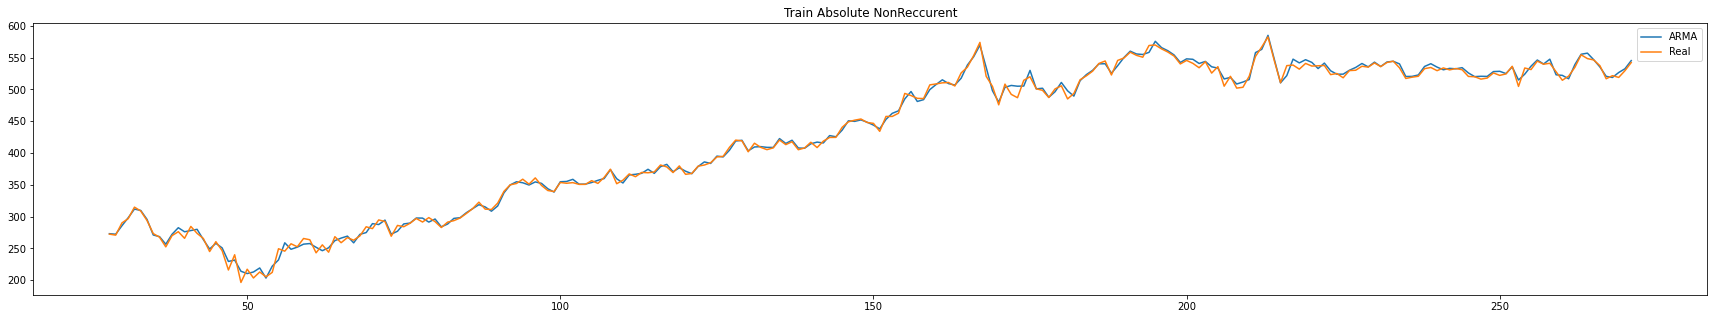

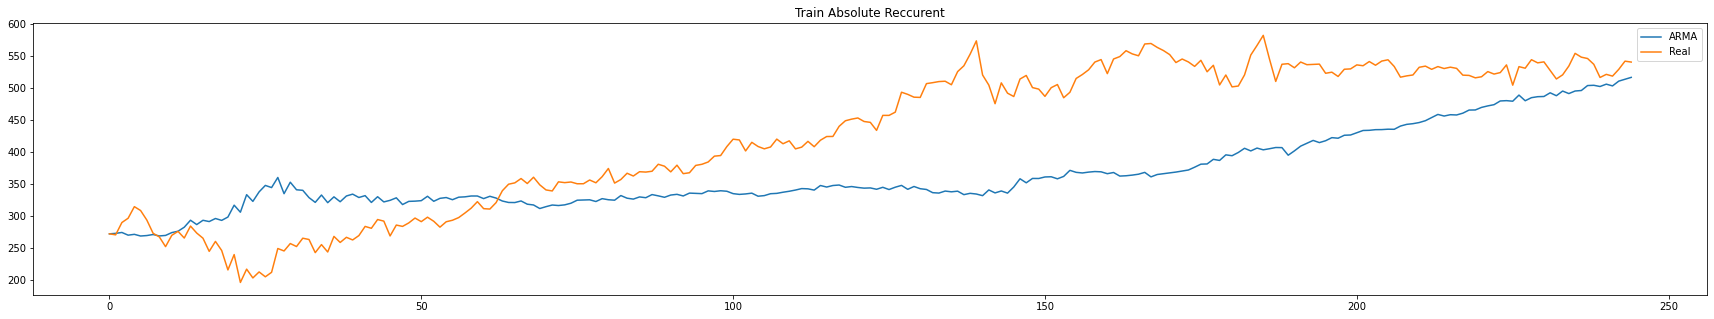

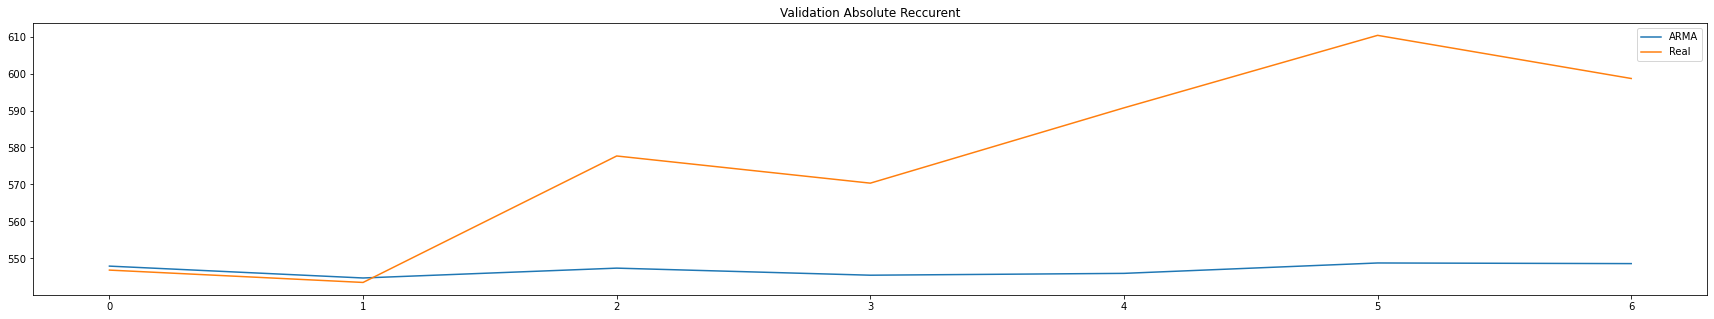

mse_train: 84.05057710306914
mse_valid: 30.563846855614788
==== Fold 4 Completed


In [10]:
cv_results = run_k_fold_tain_val_statmodels(ts, fold_ids, [(6,0,1) for _ in range(5)], [('mse', mean_absolute_error)])

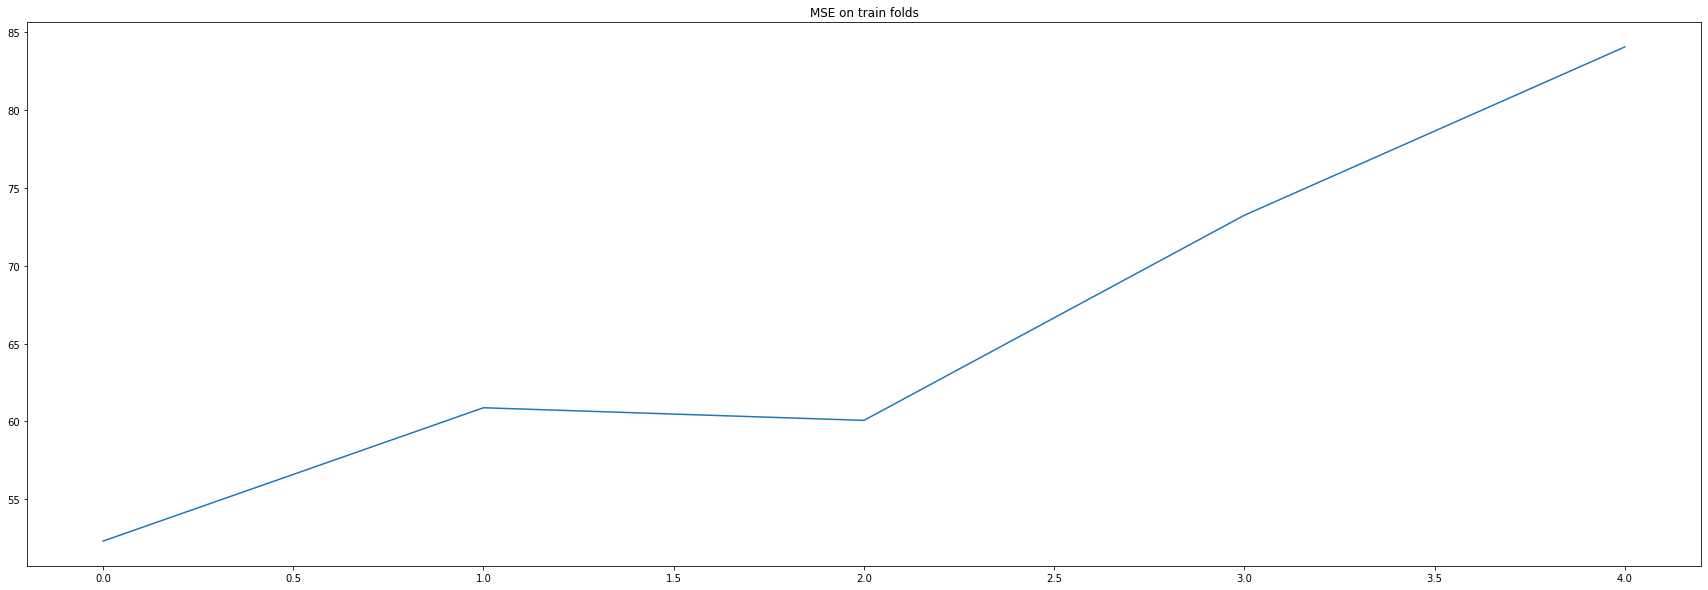

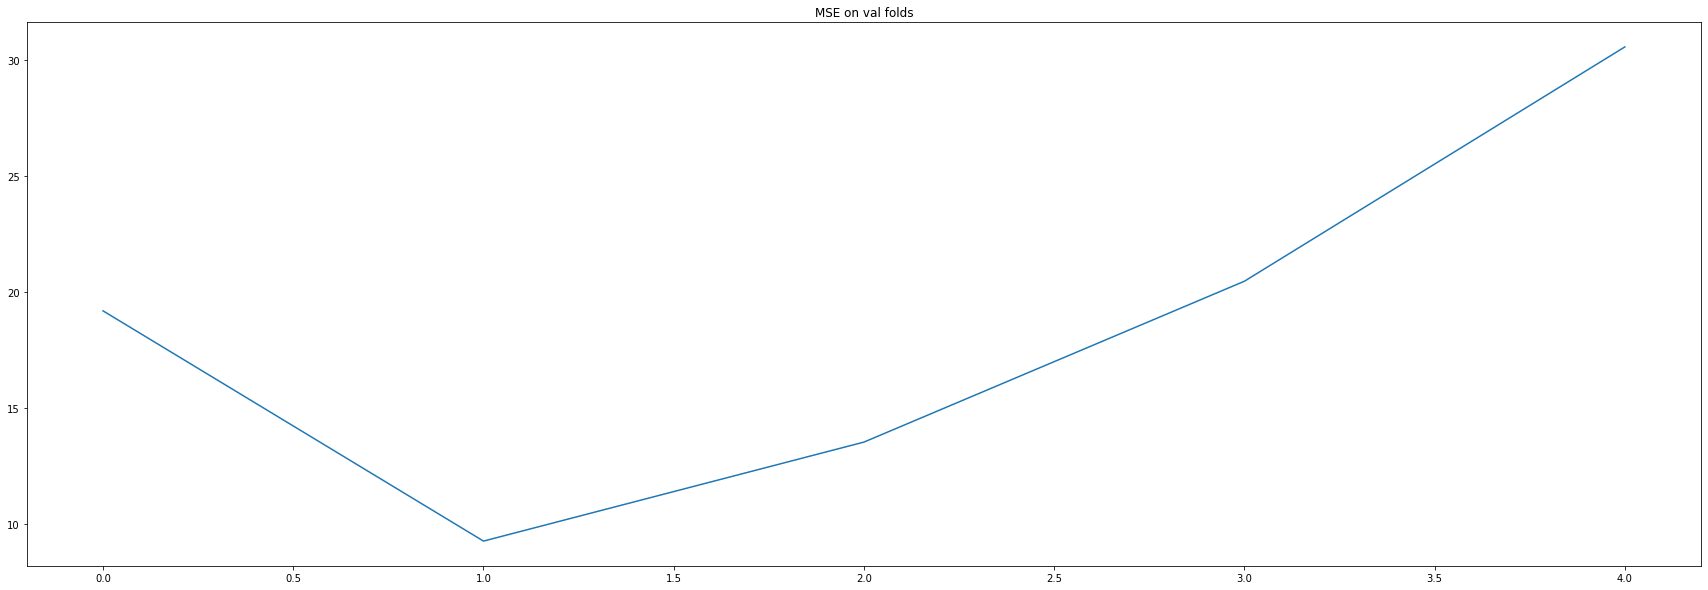

Mean Train Score: 66.11027260926491
Std Train score: 11.197176854076325
Mean Test score: 18.603814874684396
Std test score: 7.2073762570898605


In [11]:
plt.title("MSE on train folds")
plt.plot(cv_results['mse_train'])
plt.show()

plt.title("MSE on val folds")
plt.plot(cv_results['mse_valid'])
plt.show()

print("Mean Train Score: {}\nStd Train score: {}\nMean Test score: {}\nStd test score: {}".format(
    np.mean(cv_results['mse_train']),
    np.std(cv_results['mse_train']),
    np.mean(cv_results['mse_valid']),
    np.std(cv_results['mse_valid'])
))